# Chapter 8 - Wavefront Aberrations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, fft, ifft, ifftshift

# Define the rect function
def rect(x):
    return np.where(np.abs(x) <= 0.5, 1, 0)

def comb(x):
    # Dirac delta approximation: 1 where x is an integer, 0 otherwise
    return np.where(np.abs(x - np.round(x)) < 3e-2, 1, 0)

def circ_(x, y, r):
    return np.where(np.sqrt(x**2 + y**2) <= r, 1, 0)

def sinc(x):
    return np.where(x == 0, 1, np.sin(x) / x)

def triangle(x):
    return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)

def gauss(x):
    return np.exp(-x**2)

def circ(r):
    return lambda x, y: np.where(np.sqrt(x**2 + y**2) <= r, 1, 0)

def propTF(u1, L, lamda, z):
    M, N = np.shape(u1)
    dx = L / M
    k = 2 * np.pi / lamda

    fx = np.linspace(-M/(2*L), M/(2*L), M) ; fy = fx
    FX, FY = np.meshgrid(fx, fy)


    H = np.exp(-1j* np.pi * lamda * z * (FX **2 + FY **2))
    H = fftshift(H)
    U1 = fft2(fftshift(u1))
    U2 = H* U1
    u2 = ifftshift(ifft2(U2))
    return u2

def propIR(u1,L,lamda,z):
    M, N = np.shape(u1)
    dx = L / M
    k = 2 * np.pi / lamda

    x = np.linspace(-L/2, L/2, M) ; y = x
    X, Y = np.meshgrid(x, y)

    h = 1 / (1j * lamda * z) * np.exp(1j * k / (2 * z) * (X ** 2 + Y ** 2))
    H = fft2(fftshift(h)) * dx ** 2
    U1 = fft2(fftshift(u1))
    U2 = H*U1
    u2 = ifftshift(ifft2(U2))

    return u2

def propFF(u1, L1, lambda_, z):
    """
    Propagation - Fraunhofer pattern
    Assumes uniform sampling

    Parameters:
    u1 : ndarray - Source plane field
    L1 : float - Source plane side length
    lambda_ : float - Wavelength
    z : float - Propagation distance

    Returns:
    u2 : ndarray - Observation plane field
    L2 : float - Observation plane side length
    """
    M, N = u1.shape  # Get input field array size
    dx1 = L1 / M  # Source sample interval
    k = 2 * np.pi / lambda_  # Wavenumber

    L2 = lambda_ * z / dx1  # Observation side length
    dx2 = lambda_ * z / L1  # Observation sample interval
    x2 = np.arange(-L2 / 2, L2 / 2, dx2)  # Observation coordinates

    X2, Y2 = np.meshgrid(x2, x2)  # Create 2D grid of observation coordinates
    c = 1 / (1j * lambda_ * z) * np.exp(1j * k / (2 * z) * (X2**2 + Y2**2))
    u2 = c * np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(u1))) * dx1**2

    return u2, L2




## 8.2 Seidel Polynomials

Seidel polynomials are often used to describe monochromatic aberrations for
rotationally symmetric optical systems, such as most lenses and mirrors. A
common form that is applied in conventional imaging systems is described by

$$
W(\vec{u}_0, \rho, \theta) = \sum_{j, m, n} W_{k l m} \vec{u}_0^k \rho^l \cos^m \theta, \quad k = 2j + m, \quad l = 2n + m
$$


where $ρ$ is a normalized radial distance in the XP and $θ$ is the angle in the XP as  shown in Fig. 8.2(a). For computational reasons the angle $\theta$ is defined here relative to the x axis in a counter-clockwise direction. $u_0$ is fractional image height or normalized image height.

$$
\rho = \sqrt{x^2 + y^2} \quad \text{and} \quad \rho \cos \theta = x,$$

and the primary aberrations are then written

$$W(\vec{u}_0; x, y) = W_d \left( x^2 + y^2 \right) + W_{040} \left( x^2 + y^2 \right)^2 + W_{131} \vec{u}_0 \left( x^2 + y^2 \right) x + W_{222} \vec{u}_0^2 x^2 + W_{220} \vec{u}_0^2 \left( x^2 + y^2 \right) + W_{311} \vec{u}_0^3 x.$$


Wd: Defocus

W404: Spherical

W131: Coma

W222: Astigmatism

W220: Field Curvature

W311:  Distortion


[[4.035      3.91692309 3.80273007 ... 3.80952636 3.92770127 4.05      ]
 [3.91692309 3.80040587 3.68774072 ... 3.69457616 3.81122404 3.93196391]
 [3.80273007 3.68774072 3.57657227 ... 3.5835252  3.69867885 3.81789332]
 ...
 [3.80952636 3.69457616 3.5835252  ... 3.9588079  4.08159836 4.20852799]
 [3.92770127 3.81122404 3.69867885 ... 4.08159836 4.20604384 4.33466128]
 [4.05       3.93196391 3.81789332 ... 4.20852799 4.33466128 4.465     ]]


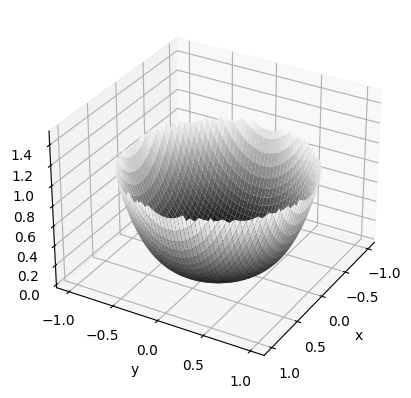

In [ ]:
#################################################################

# 8.2.1 Seidel Polynomials - Definition and primary aberrations

#################################################################

def seidel_5(u0, v0, X, Y, wd, w040, w131, w222, w220, w311):
    """
    Compute wavefront OPD for the first 5 Seidel wavefront aberration coefficients + defocus.

    Parameters:
    u0, v0 : float
        Normalized image plane coordinates.
    X, Y : array_like
        Normalized pupil coordinate arrays (from meshgrid).
    wd : float
        Defocus coefficient.
    w040 : float
        Spherical aberration coefficient.
    w131 : float
        Coma aberration coefficient.
    w222 : float
        Astigmatism coefficient.
    w220 : float
        Field curvature coefficient.
    w311 : float
        Distortion coefficient.

    Returns:
    w : array_like
        Wavefront OPD (Optical Path Difference).
    """

    # Image rotation angle
    beta = np.arctan2(v0, u0)

    # Image height
    u0r = np.sqrt(u0 ** 2 + v0 ** 2)

    # Rotate grid
    Xr = X * np.cos(beta) + Y * np.sin(beta)
    Yr = -X * np.sin(beta) + Y * np.cos(beta)

    # Seidel polynomials
    rho2 = Xr ** 2 + Yr ** 2
    w = (wd * rho2 +
         w040 * rho2 ** 2 +
         w131 * u0r * rho2 * Xr +
         w222 * u0r ** 2 * Xr ** 2 +
         w220 * u0r ** 2 * rho2 +
         w311 * u0r ** 3 * Xr)

    return w

import numpy as np

# Example input
u0, v0 = 0.5, 0.5
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
wd, w040, w131, w222, w220, w311 = 1, 0.5, 0.1, 0.2, 0.05, 0.03

# Call the function
w = seidel_5(u0, v0, X, Y, wd, w040, w131, w222, w220, w311)

print(w)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the seidel_5 function
def seidel_5(u0, v0, X, Y, wd, w040, w131, w222, w220, w311):
    beta = np.arctan2(v0, u0)
    u0r = np.sqrt(u0**2 + v0**2)
    Xr = X * np.cos(beta) + Y * np.sin(beta)
    Yr = -X * np.sin(beta) + Y * np.cos(beta)
    rho2 = Xr**2 + Yr**2
    w = (wd * rho2 +
         w040 * rho2**2 +
         w131 * u0r * rho2 * Xr +
         w222 * u0r**2 * Xr**2 +
         w220 * u0r**2 * rho2 +
         w311 * u0r**3 * Xr)
    return w



# Define the variables
u0, v0 = 1, 0
wd, w040, w131, w222, w220, w311 = 0, 1, 0, 0, 0, 0

# Create a meshgrid for X and Y
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

# Calculate the wavefront OPD
w = seidel_5(u0, v0, X, Y, wd, w040, w131, w222, w220, w311)

# Create the circular pupil function
P = circ_(X,Y,1)

# Mask where P == 0
mask = (P == 0)
w[mask] = np.nan

# Plot the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, w, cmap='gray', edgecolor='none')

# Add lighting effect
ax.view_init(30, 30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlim([0,1.5])

plt.show()


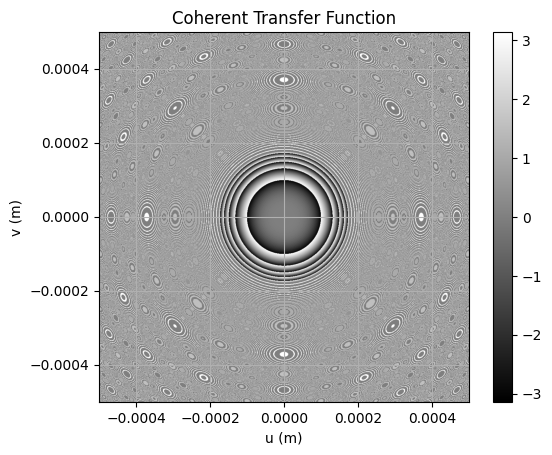

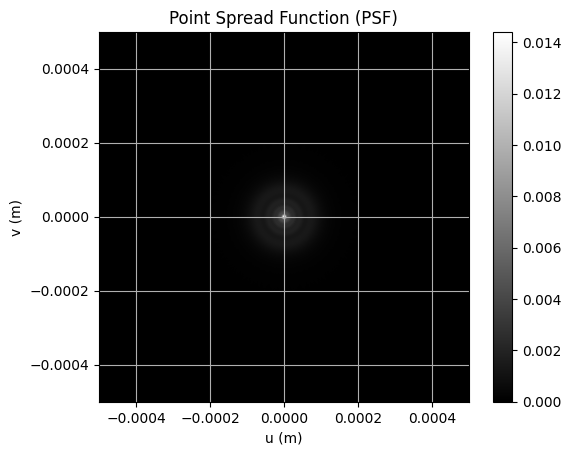

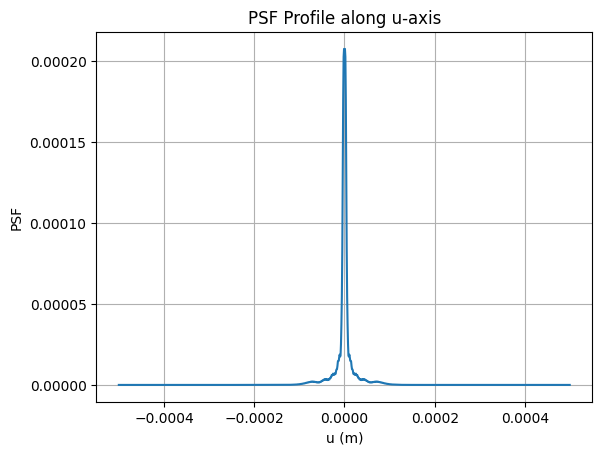

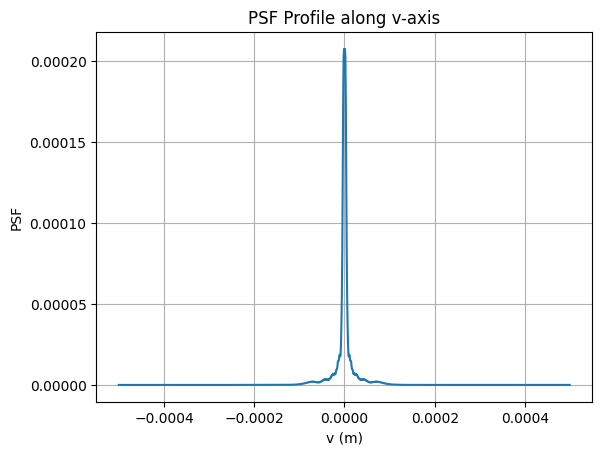

<ipython-input-5-51971558433e>:116: RuntimeWarning: invalid value encountered in arccos
  MTF_an = (2 / np.pi) * (np.arccos(fu / twof0) - (fu / twof0) * np.sqrt(1 - (fu / twof0)**2))
<ipython-input-5-51971558433e>:116: RuntimeWarning: invalid value encountered in sqrt
  MTF_an = (2 / np.pi) * (np.arccos(fu / twof0) - (fu / twof0) * np.sqrt(1 - (fu / twof0)**2))


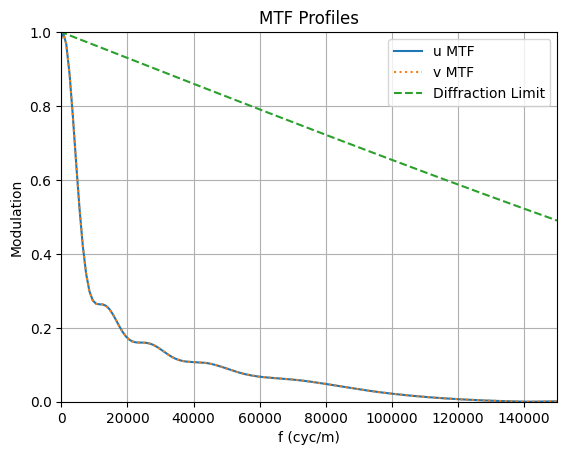

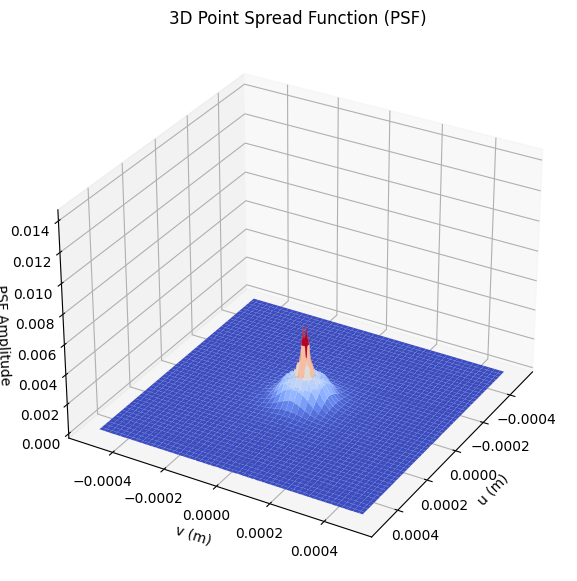

In [ ]:
#################################################################

# 8.5 Lens Example—PSF and MTF

#################################################################

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift

# Define the seidel_5 function from before
def seidel_5(u0, v0, X, Y, wd, w040, w131, w222, w220, w311):
    beta = np.arctan2(v0, u0)
    u0r = np.sqrt(u0**2 + v0**2)
    Xr = X * np.cos(beta) + Y * np.sin(beta)
    Yr = -X * np.sin(beta) + Y * np.cos(beta)
    rho2 = Xr**2 + Yr**2
    w = (wd * rho2 +
         w040 * rho2**2 +
         w131 * u0r * rho2 * Xr +
         w222 * u0r**2 * Xr**2 +
         w220 * u0r**2 * rho2 +
         w311 * u0r**3 * Xr)
    return w

# Function for circular pupil

# Constants
M = 1024
L = 1e-3
du = L / M
u = np.arange(-L/2, L/2, du)
v = u
lambda_ = 0.55e-6  # Wavelength
k = 2 * np.pi / lambda_  # Wavenumber
Dxp = 20e-3  # Exit pupil size
wxp = Dxp / 2  # Half the exit pupil size
zxp = 100e-3  # Exit pupil distance
fnum = zxp / (2 * wxp)  # Exit pupil f-number
lz = lambda_ * zxp
twof0 = 1 / (lambda_ * fnum)  # Incoherent cutoff frequency

u0 = 0  # Normalized image coordinate
v0 = 0

# Aberration coefficients
wd = 0 * lambda_
w040 = 4.963 * lambda_
w131 = 2.637 * lambda_
w222 = 9.025 * lambda_
w220 = 7.536 * lambda_
w311 = 0.157 * lambda_

# Image frequency coordinates
fu = np.linspace(-1/(2*du), 1/(2*du), int(L/du))
Fu, Fv = np.meshgrid(fu, fu)

# Wavefront
W = seidel_5(u0, v0, -lz * Fu / wxp, -lz * Fv / wxp, wd, w040, w131, w222, w220, w311)

# Coherent transfer function
H = circ_(Fu, Fv,  wxp/lz) * np.exp(-1j * k * W)

# Plot the coherent transfer function
plt.figure(1)
plt.imshow(np.angle(H), extent=[u[0], u[-1], v[0], v[-1]], cmap='gray', origin='lower')
plt.xlabel('u (m)')
plt.ylabel('v (m)')
plt.axis('square')
plt.colorbar()
plt.title('Coherent Transfer Function')
plt.grid(True)

plt.show()

# Point Spread Function
h2 = np.abs(ifftshift(ifft2(fftshift(H))))**2

# Plot PSF image
plt.figure(2)
plt.imshow(np.sqrt(h2), extent=[u[0], u[-1], v[0], v[-1]], cmap='gray', origin='lower')
plt.xlabel('u (m)')
plt.ylabel('v (m)')
plt.axis('square')
plt.colorbar()
plt.title('Point Spread Function (PSF)')
plt.grid(True)

plt.show()

# Plot PSF profiles
plt.figure(3)
plt.plot(u, h2[M//2, :])
plt.xlabel('u (m)')
plt.ylabel('PSF')
plt.title('PSF Profile along u-axis')
plt.grid(True)

plt.show()

plt.figure(4)
plt.plot(u, h2[:, M//2])
plt.xlabel('v (m)')
plt.ylabel('PSF')
plt.title('PSF Profile along v-axis')
plt.grid(True)

plt.show()

# MTF (Modulation Transfer Function)
MTF = np.abs(fft2(fftshift(h2)))
MTF = MTF / MTF[0, 0]  # Normalize DC component to 1
MTF = ifftshift(MTF)

# Analytic MTF
MTF_an = (2 / np.pi) * (np.arccos(fu / twof0) - (fu / twof0) * np.sqrt(1 - (fu / twof0)**2))
MTF_an = MTF_an * (np.abs(fu) <= twof0)  # Zero after cutoff

# Plot MTF profiles
plt.figure(5)
plt.plot(fu, MTF[M//2, :], label='u MTF')
plt.plot(fu, MTF[:, M//2], ':', label='v MTF')
plt.plot(fu, MTF_an, '--', label='Diffraction Limit')
plt.axis([0, 150000, 0, 1])
plt.legend()
plt.xlabel('f (cyc/m)')
plt.ylabel('Modulation')
plt.title('MTF Profiles')
plt.grid(True)
plt.show()


# Add 3D plotting import
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure for the 3D PSF plot
fig = plt.figure(figsize=(10, 7))

# Create a 3D axis
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for u and v
U, V = np.meshgrid(u, v)

# Plot the 3D surface for the PSF
ax.plot_surface(U, V, np.sqrt(h2), cmap= "coolwarm", edgecolor='none')

# Add labels and title
ax.set_title('3D Point Spread Function (PSF)')
ax.set_xlabel('u (m)')
ax.set_ylabel('v (m)')
ax.set_zlabel('PSF Amplitude')

# Adjust the view angle for better visualization
ax.view_init(30, 30)


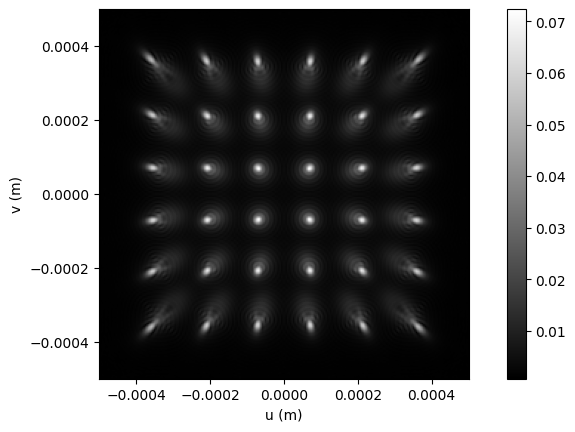

In [ ]:
#################################################################

# 8.7 Superposition Imaging Example

#################################################################

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fft2, fftshift, ifft, ifft2, ifftshift
from scipy.ndimage import shift


def seidel_5(u0, v0, X, Y, wd, w040, w131, w222, w220, w311):
    beta = np.arctan2(v0, u0)
    u0r = np.sqrt(u0**2 + v0**2)
    Xr = X * np.cos(beta) + Y * np.sin(beta)
    Yr = -X * np.sin(beta) + Y * np.cos(beta)
    rho2 = Xr**2 + Yr**2
    w = (wd * rho2 +
         w040 * rho2**2 +
         w131 * u0r * rho2 * Xr +
         w222 * u0r**2 * Xr**2 +
         w220 * u0r**2 * rho2 +
         w311 * u0r**3 * Xr)
    return w

pi = np.pi
j = 1j
M= 250
L = 1e-3
du = L/M
u = np.linspace(-L/2, L/2, M)
v = u

lambda_ = 0.5e-6
k = 2*pi/lambda_
wxp = 2.5e-3
zxp = 100e-3
fnum = zxp / (2*wxp)

twof0 = 1/ (lambda_ * fnum)
fN = M/ (2* L)

wd = 0 * lambda_
w040 = 0.5 * lambda_
w131 = 1 * lambda_
w222 = 1.5 * lambda_
w220 = 0 * lambda_
w311 = 0 * lambda_

fu = np.linspace(-M/(2*L),M/(2*L), M)
fu = fftshift(fu)
Fu, Fv = np.meshgrid(fu, fu)

I = np.zeros((M,M))

# Loop through image plane positions
for u0 in np.linspace(-0.7, 0.7, 6):
    for v0 in np.linspace(-0.7, 0.7, 6):
        # Wavefront aberration calculation
        W = seidel_5(u0, v0, -2 * lambda_ * fnum * Fu, -2 * lambda_ * fnum * Fv, wd, w040, w131, w222, w220, w311)

        # Coherent transfer function
        H = circ_(Fu, Fv,  (2 * lambda_ * fnum)**-1) * np.exp(-1j * k * W)

        # Point Spread Function (PSF)
        h2 = np.abs(ifftshift(ifft2(H))) ** 2

        # Shift PSF to image plane position
        h2 = shift(h2, [round(v0 * M / 2), round(u0 * M / 2)], mode='wrap')

        # Add into the combined frame
        I += h2

# Display the image using nth root scaling and plot settings
plt.figure(1)
plt.imshow(np.power(I, 1/2), extent=[u.min(), u.max(), v.min(), v.max()], cmap='gray', aspect='equal', origin='lower')
plt.xlabel('u (m)')
plt.ylabel('v (m)')
plt.colorbar()  # Optional: to add a color bar
plt.axis('square')
plt.show()


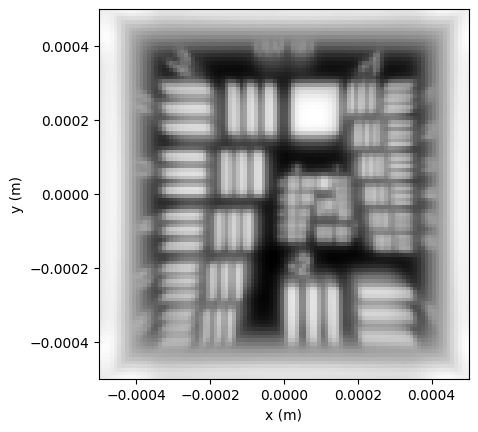

'\nSome comments on image_super:\n(a) Line 31: To avoid the time required to “flip” the PSF within the for\nloops, the frequency coordinate vector fu is reversed.\n\n(b) Line 32: fu is shifted to avoid using fftshift on H in line 49 (a time\nsaver).\n\n(c) Line 36: for loops are used to step through each position in the\nimage plane corresponding to all coordinate pairs u0ˆ , v0ˆ .\n\n(d) Lines 37 and 38: The first loop involves the row index n. Because of\nMATLAB’s row/column ordering, this index corresponds to the yaxis variable v0.\nThis is one of the few times in this book where it is\nnecessary to use the index values to derive physical parameter\nvalues. Looping with the index is forced by line 53, where each\nirradiance matrix element is addressed.\n\n(e) Lines 39 and 40: The second loop involves the row index m\ncorresponding to the x-axis variable u0.\n\n(f) Line 51: circshift is applied using the index variables, which has\nthe same effect as the approach used with circshift 

In [ ]:
#################################################################

# 8.7.2 Image Simulation

#################################################################


import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from skimage.io import imread
from skimage.color import rgb2gray
from PIL import Image
import scipy as sc



def seidel_5(u0, v0, X, Y, wd, w040, w131, w222, w220, w311):
    beta = np.arctan2(v0, u0)
    u0r = np.sqrt(u0**2 + v0**2)
    Xr = X * np.cos(beta) + Y * np.sin(beta)
    Yr = -X * np.sin(beta) + Y * np.cos(beta)
    rho2 = Xr**2 + Yr**2
    w = (wd * rho2 +
         w040 * rho2**2 +
         w131 * u0r * rho2 * Xr +
         w222 * u0r**2 * Xr**2 +
         w220 * u0r**2 * rho2 +
         w311 * u0r**3 * Xr)
    return w


# Load the image file (make sure the file path is correct)
# Load the image
pi = np.pi
j = 1j

A = Image.open('USAF1951.png',).convert('L').resize((100,100))
M, N = np.shape(A); A = np.flipud(A)
Ig = np.single(A); Ig = Ig/np.max(np.max(Ig))

L = 1e-3
du = L/M
u = np.linspace(-L/2, L/2, M); v = u
fN = M / (2*L)

lambda_ = 0.5e-6
k = 2*pi/lambda_
wxp = 2.5e-3
zxp = 100e-3
fnum = zxp/(2*wxp)

twof0 = 1/(lambda_* fnum)
fN = M/(2*L)


wd = 0 * lambda_
w040 = 0.5 * lambda_
w131 = 1 * lambda_
w222 = 1.5 * lambda_
w220 = 0 * lambda_
w311 = 0 * lambda_



fu = np.linspace(M/(2*L), -M/(2*L), M)
fu = fftshift(fu)
Fu, Fv = np.meshgrid(fu,fu)

I = np.zeros((M,M))
# Loop through image plane positions
for n in range(M):
    v0 = (n - (M / 2 + 1)) / (M / 2)  # Normalized v image coord
    for m in range(M):
        u0 = (m - (M / 2 + 1)) / (M / 2)  # Normalized u image coord

        # Wavefront calculation using Seidel aberrations
        W = seidel_5(u0, v0, -2 * lambda_ * fnum * Fu, -2 * lambda_ * fnum * Fv, wd, w040, w131, w222, w220, w311)

        # Coherent transfer function
        H = circ_(Fu, Fv, (2 * lambda_ * fnum)**-1) * np.exp(-1j * k * W)

        # Point Spread Function (PSF)
        h2 = np.abs(ifftshift(ifft2(H)))**2

        # Shift PSF to the image plane position
        h2 = np.roll(np.roll(h2, n - int(M / 2 + 1), axis=0), m - int(M / 2 + 1), axis=1)

        # Superposition integration
        I[n, m] = np.sum(Ig * h2)

# Now `I` contains the final image plane intensity.

# Plot the image
plt.figure(1)
plt.imshow(np.cbrt(I), extent=(u.min(), u.max(), v.min(), v.max()), cmap='gray', aspect='equal', origin='lower')

# Set axis labels
plt.xlabel('x (m)')
plt.ylabel('y (m)')

# Show the plot with a square axis
plt.axis('square')

# Show the plot
plt.show()

'''
Some comments on image_super:
(a) Line 31: To avoid the time required to “flip” the PSF within the for
loops, the frequency coordinate vector fu is reversed.

(b) Line 32: fu is shifted to avoid using fftshift on H in line 49 (a time
saver).

(c) Line 36: for loops are used to step through each position in the
image plane corresponding to all coordinate pairs u0ˆ , v0ˆ .

(d) Lines 37 and 38: The first loop involves the row index n. Because of
MATLAB’s row/column ordering, this index corresponds to the yaxis variable v0.
This is one of the few times in this book where it is
necessary to use the index values to derive physical parameter
values. Looping with the index is forced by line 53, where each
irradiance matrix element is addressed.

(e) Lines 39 and 40: The second loop involves the row index m
corresponding to the x-axis variable u0.

(f) Line 51: circshift is applied using the index variables, which has
the same effect as the approach used with circshift in psf_map.

(g) Line 53: Finally, the superposition integral [Eq. (8.17)] is performed.

(h) A final comment: This code takes a relatively long time to execute!
(About an hour on my laptop.) Individual PSFs (250  250 = 62,500)
are created and incorporated in the superposition frame. Compare
this with a convolution result that involves a single PSF and can be
accomplished in fractions of a second with a few fast Fourier
tranforms. The luxury of a convolution is not available in this case.

'''

